In [1]:
import numpy as np
import os
import random
from copy import deepcopy
import torchvision, cv2
from skimage import filters, morphology, restoration, transform
import matplotlib as plt
from pathlib import Path
from utils.plots import plot_confusion_matrix
import utils.dataset as ds
from utils.transforms import *
from utils.visualizations import *
from utils.experiment import Experiment

In [2]:
import utils.dataset as ds
import torchvision, cv2
import importlib

importlib.reload(ds)

physionet = ds.PhysionetDataset(train=True)
slp = ds.SLPDataset(train=True)
ambienta = ds.AmbientaDataset(train=True)
cifar = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)

Files already downloaded and verified


In [3]:
indices_per_class_physionet = {}
for i, label in enumerate(ds.PostureClass):
    indices_per_class_physionet[i] = np.where(physionet.y == i)[0]

indices_per_class_slp = {}
for i, label in enumerate(ds.PostureClass):
    indices_per_class_slp[i] = np.where(slp.y == i)[0]

physionet_samples = [
    sample
    for sample in map(
        lambda c: physionet[random.choice(c)] if len(c) > 0 else None,
        list(indices_per_class_physionet.values()) * 5,
    )
    if sample is not None
]

slp_samples = [
    sample
    for sample in map(
        lambda c: slp[random.choice(c)] if len(c) > 0 else None,
        list(indices_per_class_slp.values()) * 5,
    )
    if sample is not None
]

samples = physionet_samples * 2
samples[5::10] = slp_samples[::5]
samples[6::10] = slp_samples[1::5]
samples[7::10] = slp_samples[2::5]
samples[8::10] = slp_samples[3::5]
samples[9::10] = slp_samples[4::5]

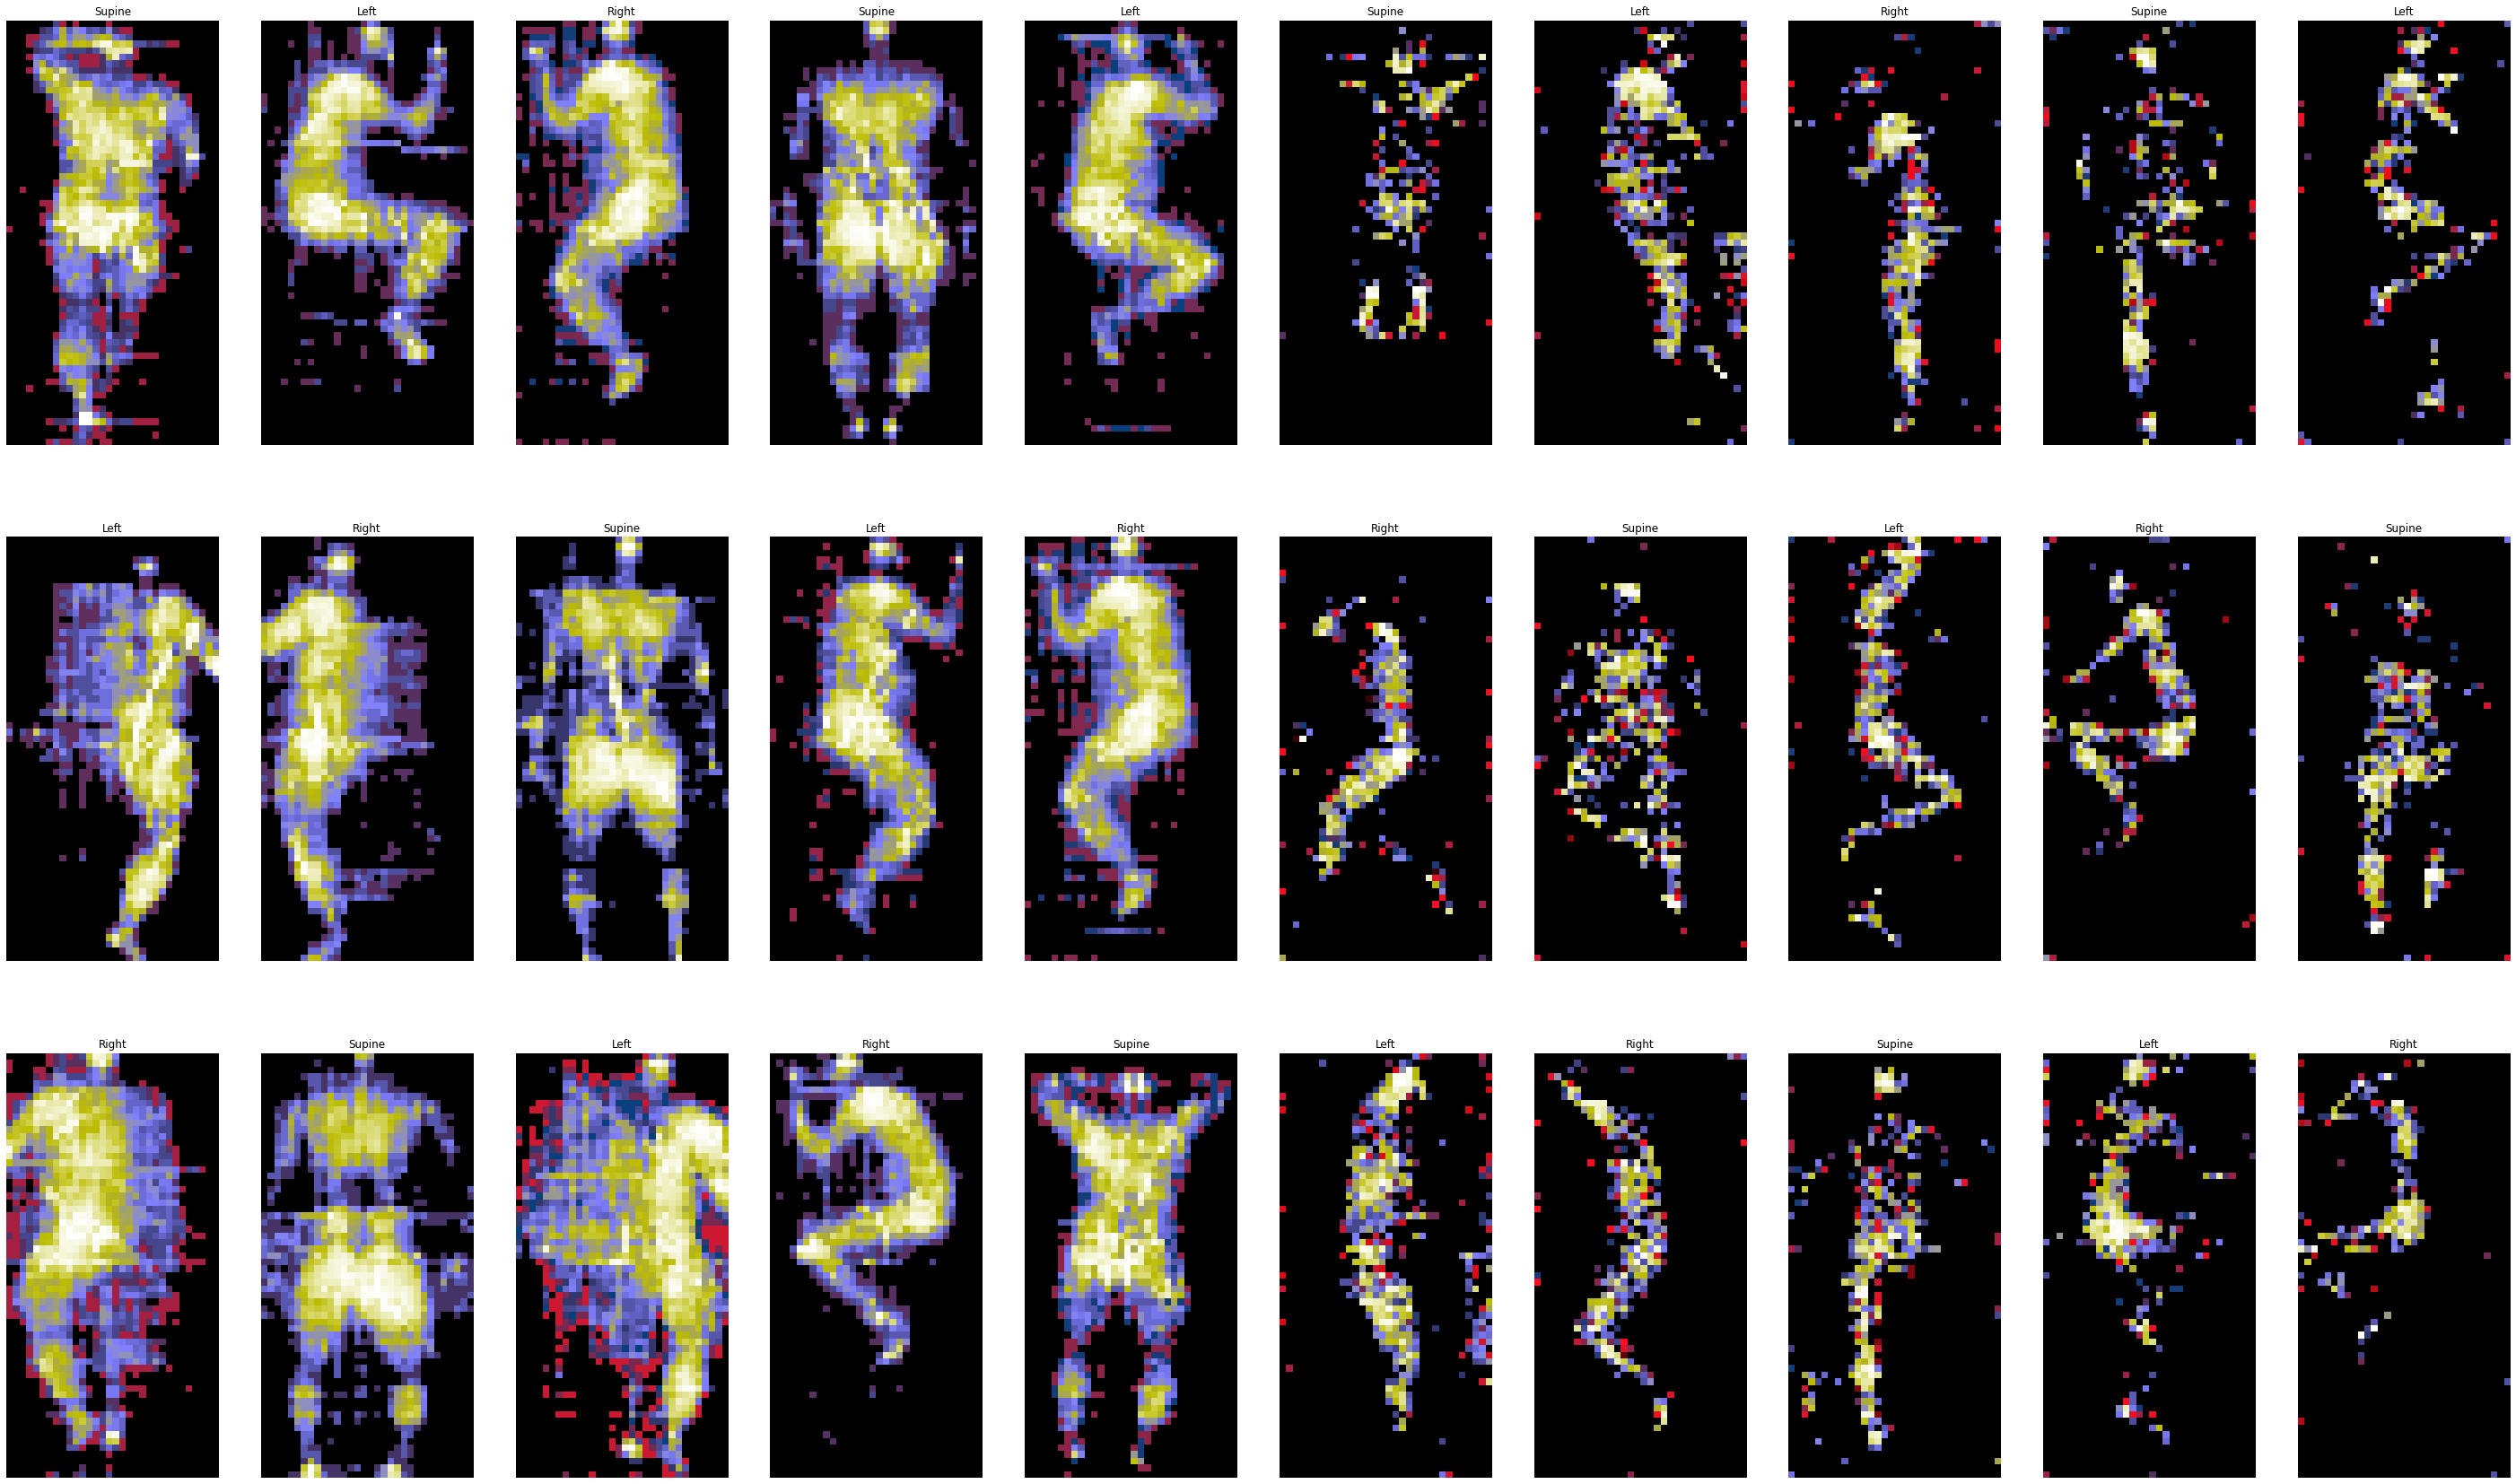

In [5]:
normalizations = [
    Resize((32, 64)),
    Standardize(),
    NormalizeMinMax(),
    EqualizeHist(),
]


plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        normalizations
    ),
)

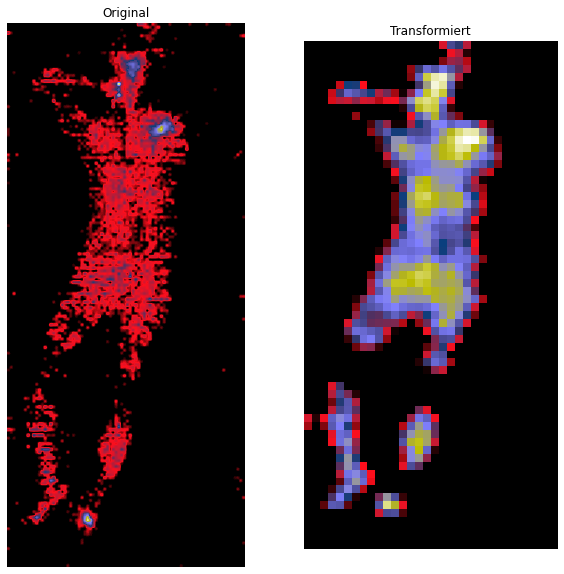

In [15]:
t = torchvision.transforms.Compose(
    [
        # Resize((32, 64)),
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Blur((3, 3)),
        Denoise(),
        Threshold(lambda img: np.median(img[img > 0.0])),
        Close((3, 3), ktype=cv2.MORPH_CROSS, iterations=3),
        # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=3),
        Blur((3, 3)),
        Resize((32, 64)),
        # Threshold(lambda img: np.median(img)),
        # Close((2, 4), ktype=cv2.MORPH_CROSS, iterations=2),
        # Erode((2,2), ktype=cv2.MORPH_CROSS, iterations=2),
        # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=2),
    ]
)

images = [slp[7][0], t(slp[7][0])]

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
for i, (col, image) in enumerate(zip(axs, images)):
    plot_image(image, title="Original" if i == 0 else "Transformiert", ax=col)

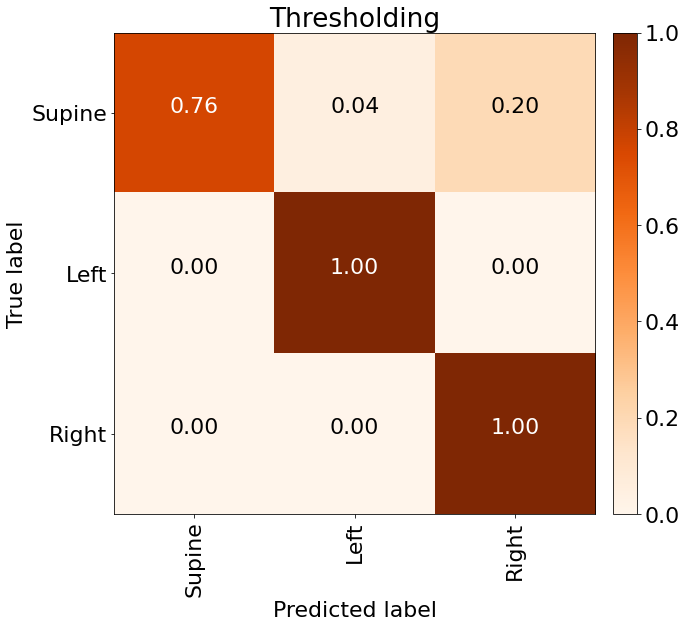

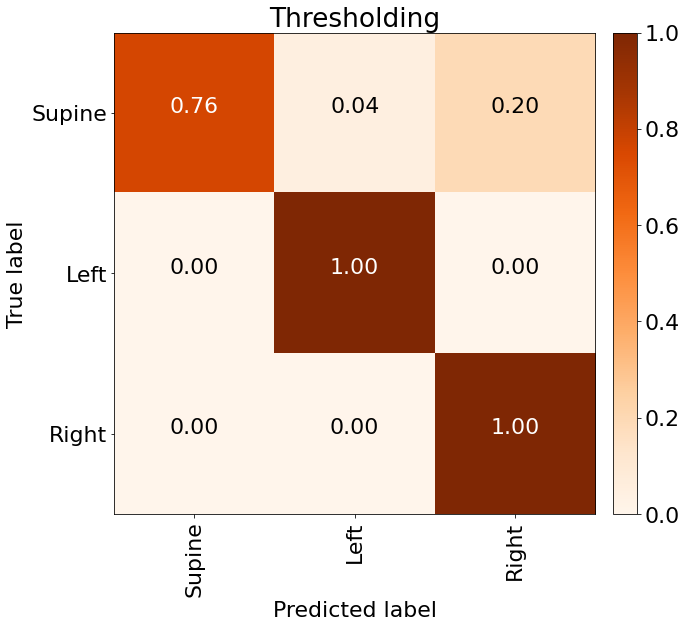

In [3]:
path = Path("runs").joinpath("2022-05-30_08-42-10_Baseline").joinpath("confmat.npy")
conf_mat = np.load(str(path))
plot_confusion_matrix(conf_mat, title="Thresholding", normalize=True)

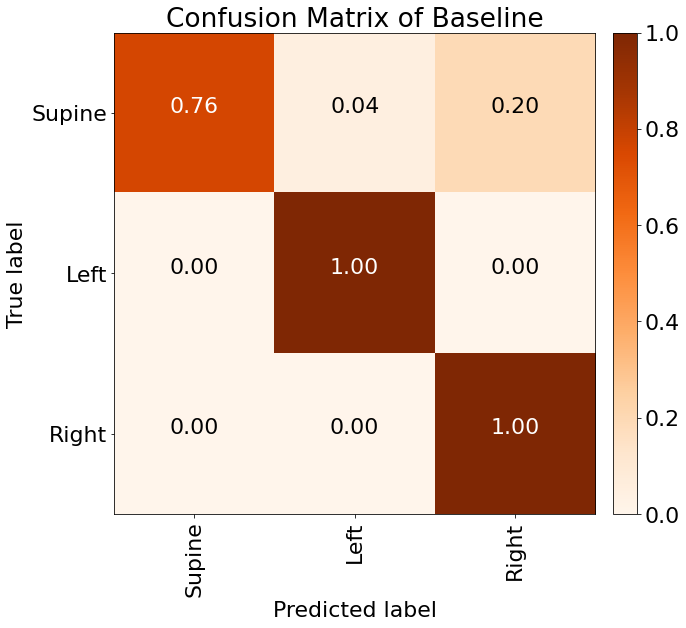

In [2]:
Experiment.reevaluate("2022-05-30_08-42-10_Baseline")

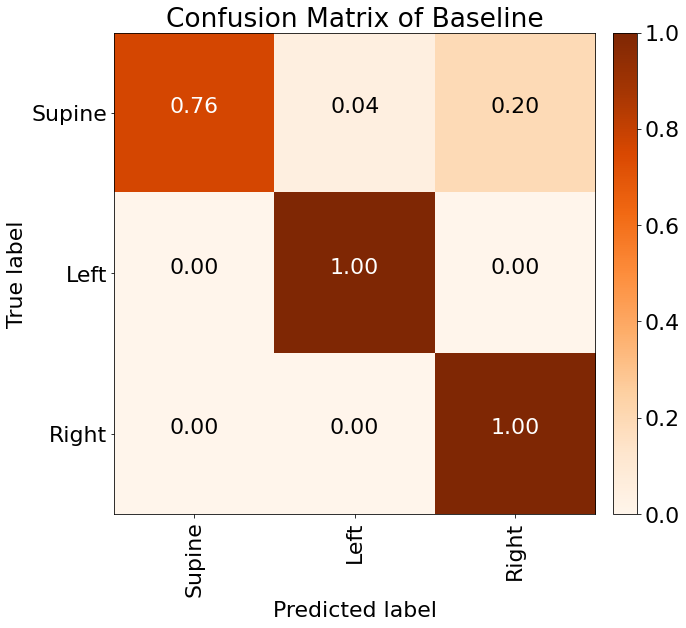

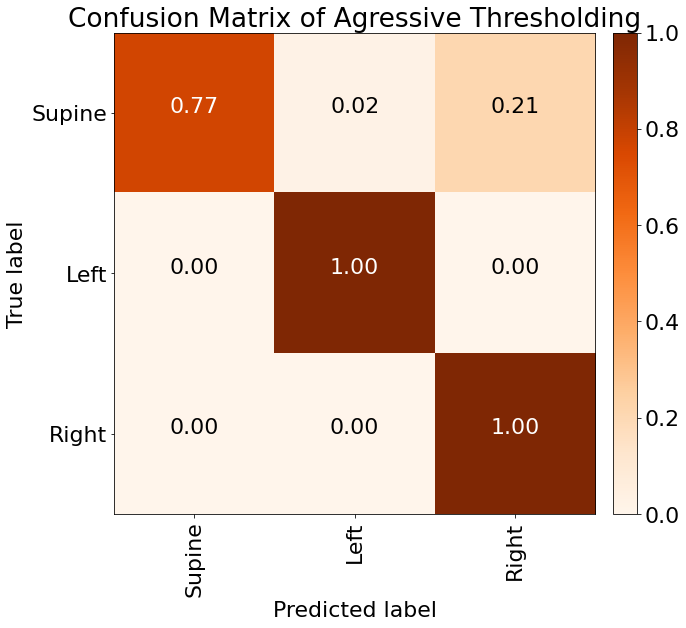

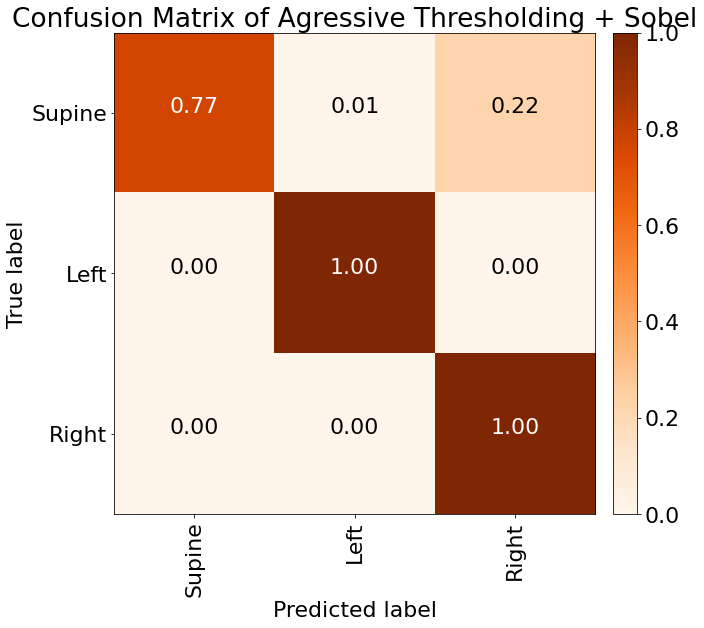

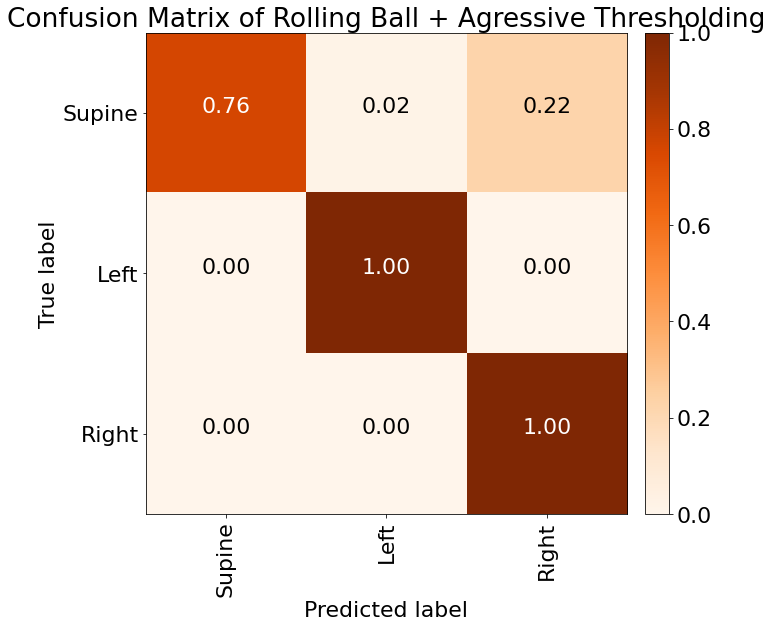

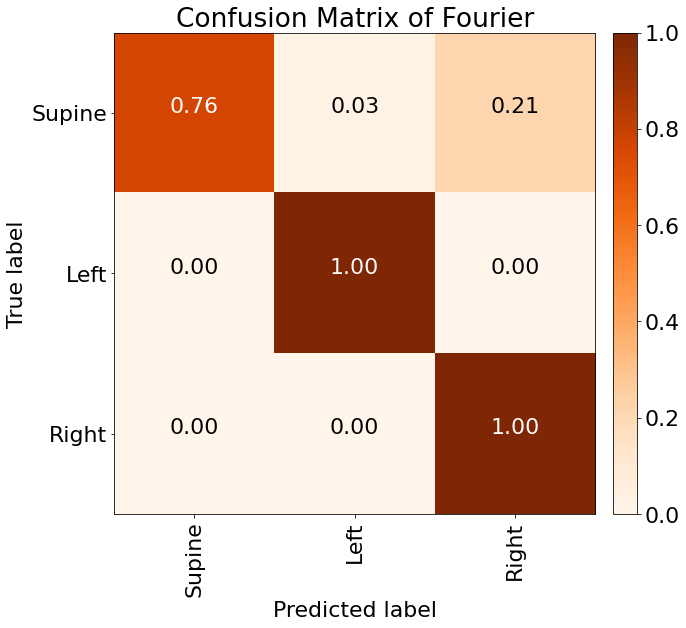

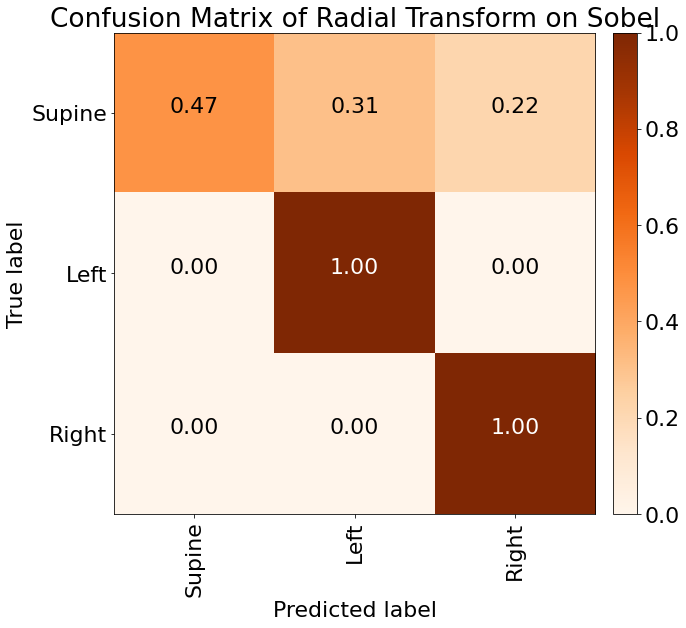

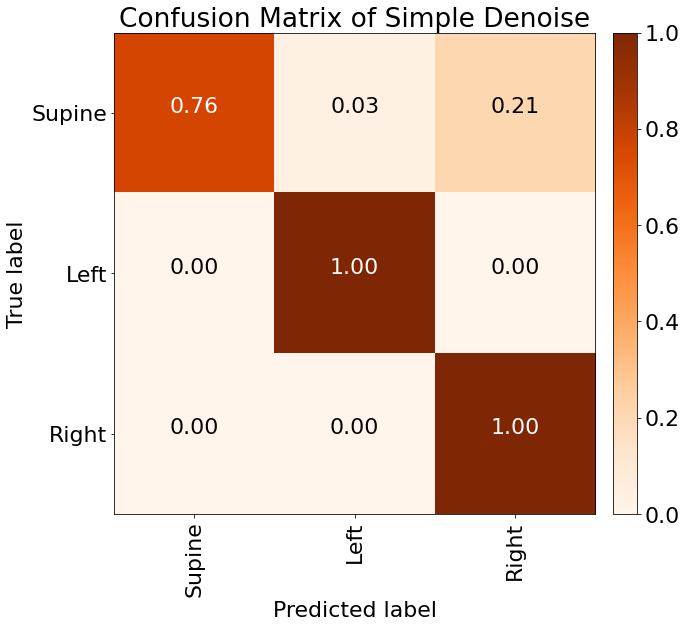

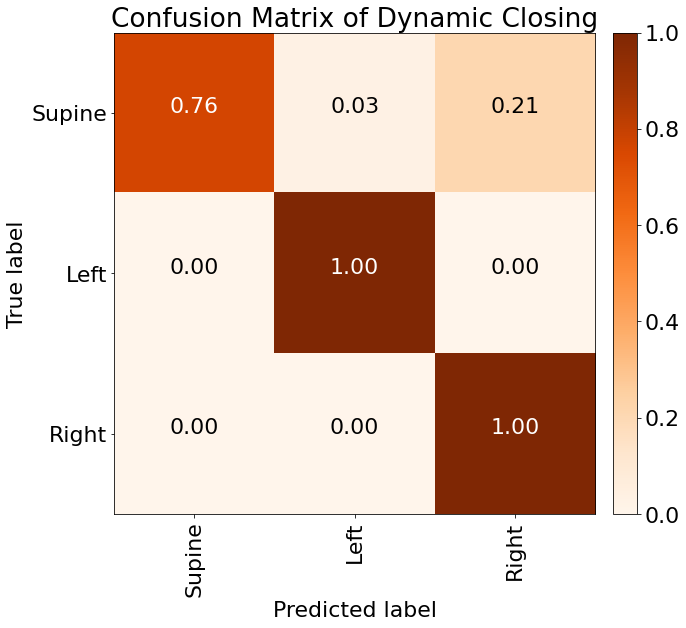

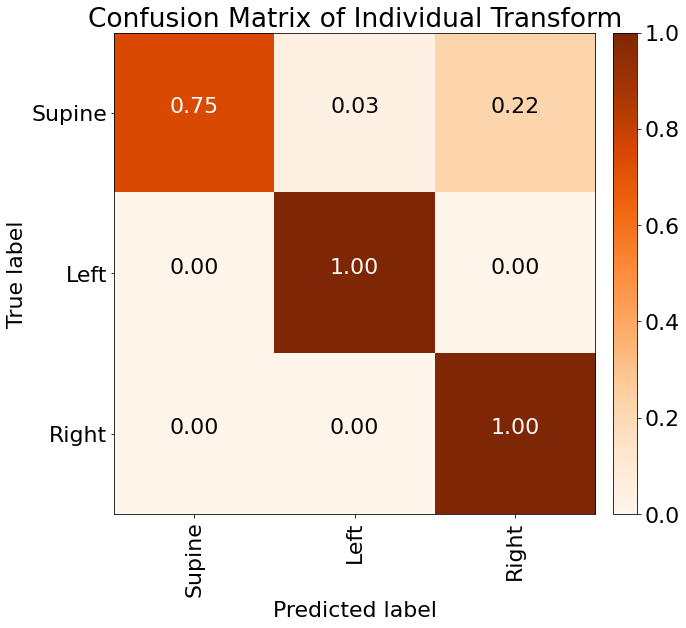

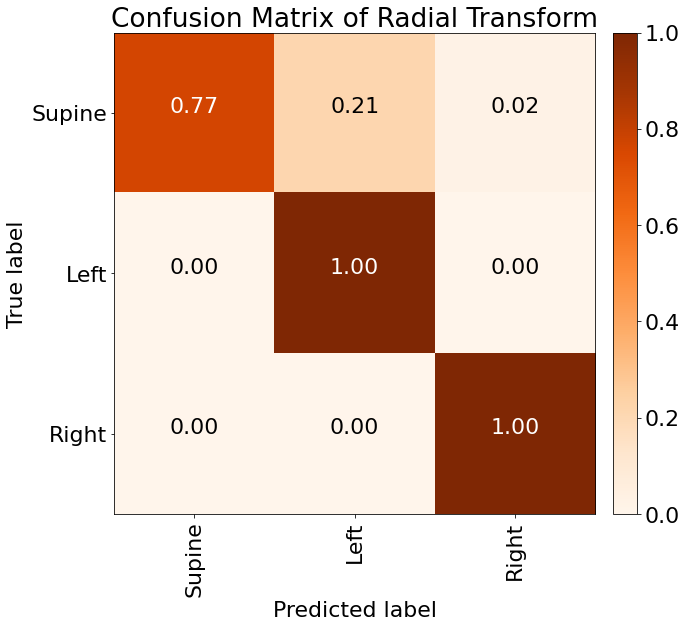

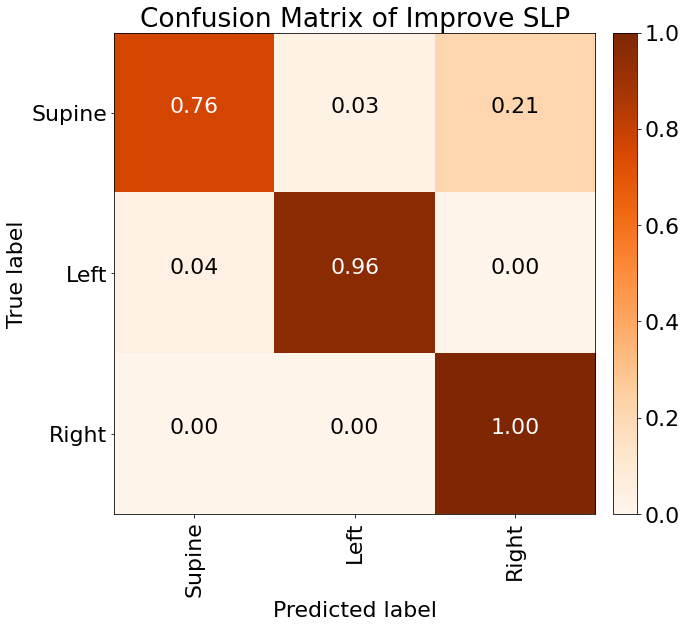

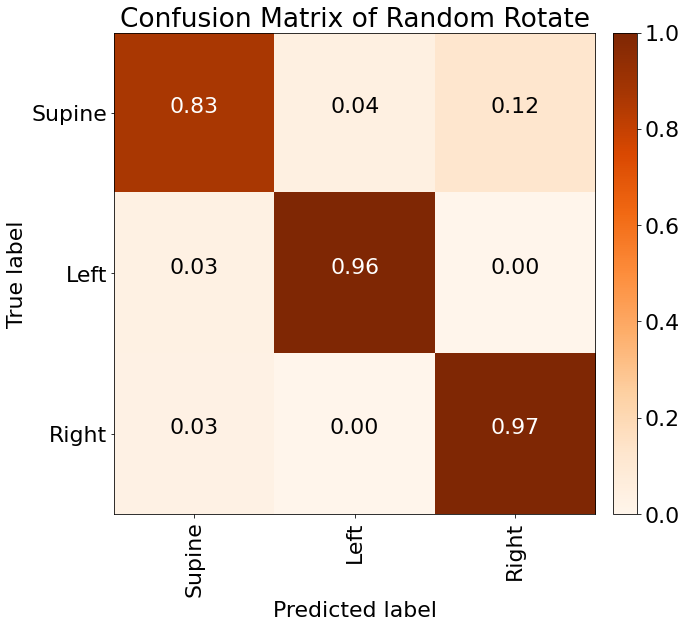

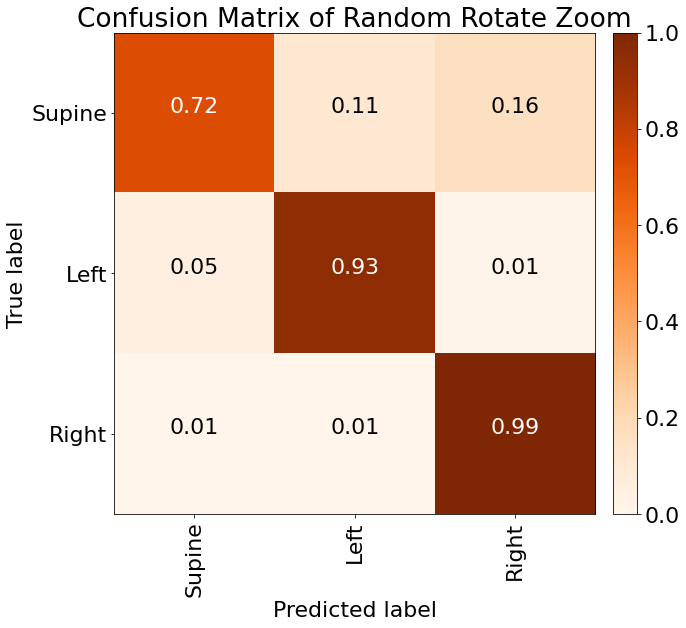

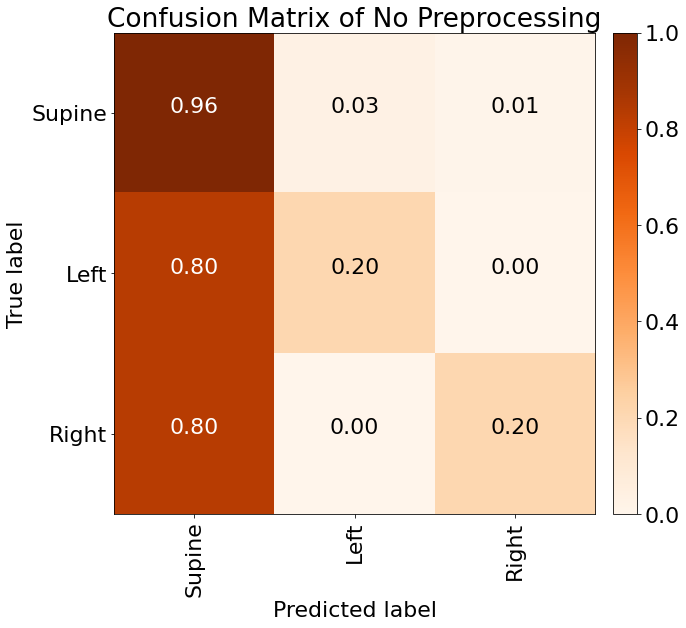

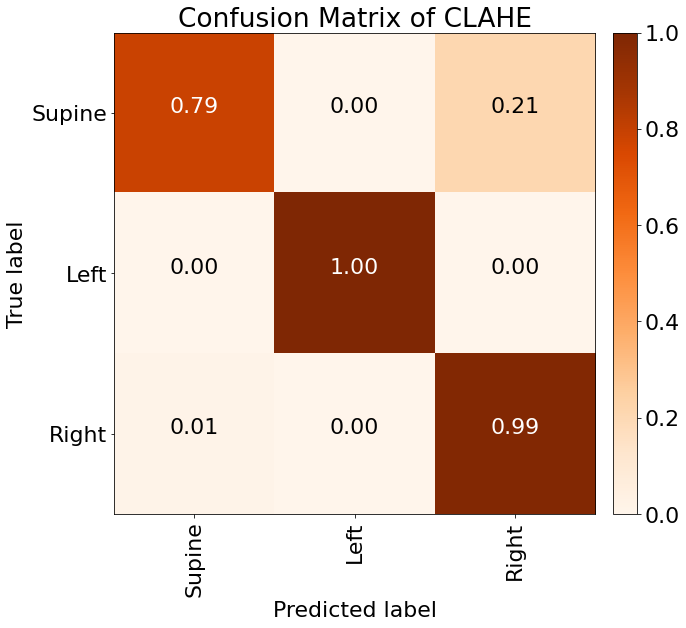

In [5]:
dirs = os.listdir(Path("runs"))
matrices = []
for run in dirs:
    path = Path("runs").joinpath(run).joinpath("confmat.npy")
    conf_mat = np.load(str(path))
    with open(f"runs/{run}/name.txt", "r") as f:
        name = f.read()
    fig = plot_confusion_matrix(conf_mat, title=f"Confusion Matrix of {name}", normalize=True)
    fig.set_facecolor("white")
    fig.savefig("cf.png")
    data = plt.imread("cf.png")
    data = torch.from_numpy(data.copy()).permute(2, 0, 1)
    matrices.append(data)
    os.remove("cf.png")
image_grid = torchvision.utils.make_grid(torch.stack(matrices), nrow=4)
torchvision.utils.save_image(image_grid.float(), "images/confmats.png")